<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-records" data-toc-modified-id="Load-records-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load records</a></span></li><li><span><a href="#Transforms-and-dataloaders" data-toc-modified-id="Transforms-and-dataloaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transforms and dataloaders</a></span></li><li><span><a href="#Model-and-training" data-toc-modified-id="Model-and-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model and training</a></span></li><li><span><a href="#Show-results" data-toc-modified-id="Show-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Show results</a></span></li></ul></div>

In [1]:
from mantisshrimp.all import *

## Load records

In [2]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [3]:
class PersonImageParser(ImageParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        # Get size
        sz = self.lines.filter(lambda o: o.startswith('Image size (X x Y x C)'))[0]
        sz = re.search(r'\d{3,4}\sx\s\d{3,4}\sx\s3', sz).group()
        self.sz = lmap(int, sz.split('x'))
        
    def iid(self, o): return self.i
    def file_path(self, o):
        fp = self.lines.filter(lambda o: o.startswith('Image filename'))[0]
        fp = re.findall(r'"(.*)"', fp)[0]
        return self.source.parent/fp
    
    def width(self, o):  return self.sz[0]
    def height(self, o): return self.sz[1]

In [4]:
class PersonAnnotationParser(AnnotationParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        ln = self.lines.filter(lambda o: o.startswith('Objects with ground truth'))[0]
        self.n = int(re.findall('\d+', ln)[0])
        
    def iid(self, o): return self.i
    def oid(self, o): return [1]*self.n
    def iscrowd(self, o): return [0]*self.n
        
    def bbox(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Bounding box'))
        bboxes = []
        for bbox in lines:
            bbox = re.findall(r'(\d+,\s\d+)', bbox)
            bbox = lmap(lambda o: lmap(int, o.split(',')), bbox)
            bbox = np.array(bbox).flat
            bboxes.append(BBox.from_xyxy(*bbox))
        return bboxes
    
    def seg(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Pixel mask for object'))
        line = lines[0] # All lines contain the same mask
        fp = self.source.parent/re.findall(r'"(.+)"', line.split(':')[-1])[0]
        return MaskFile(fp)

In [5]:
fns = get_files(source/'Annotation', extensions='.txt')

In [6]:
id2cat = {1: 'person'}

In [7]:
parser = DataParser(fns, source, img_parser=PersonImageParser, annot_parser=PersonAnnotationParser)
rtrain,rvalid = parser.parse()


Removed 0 images that don't have annotations


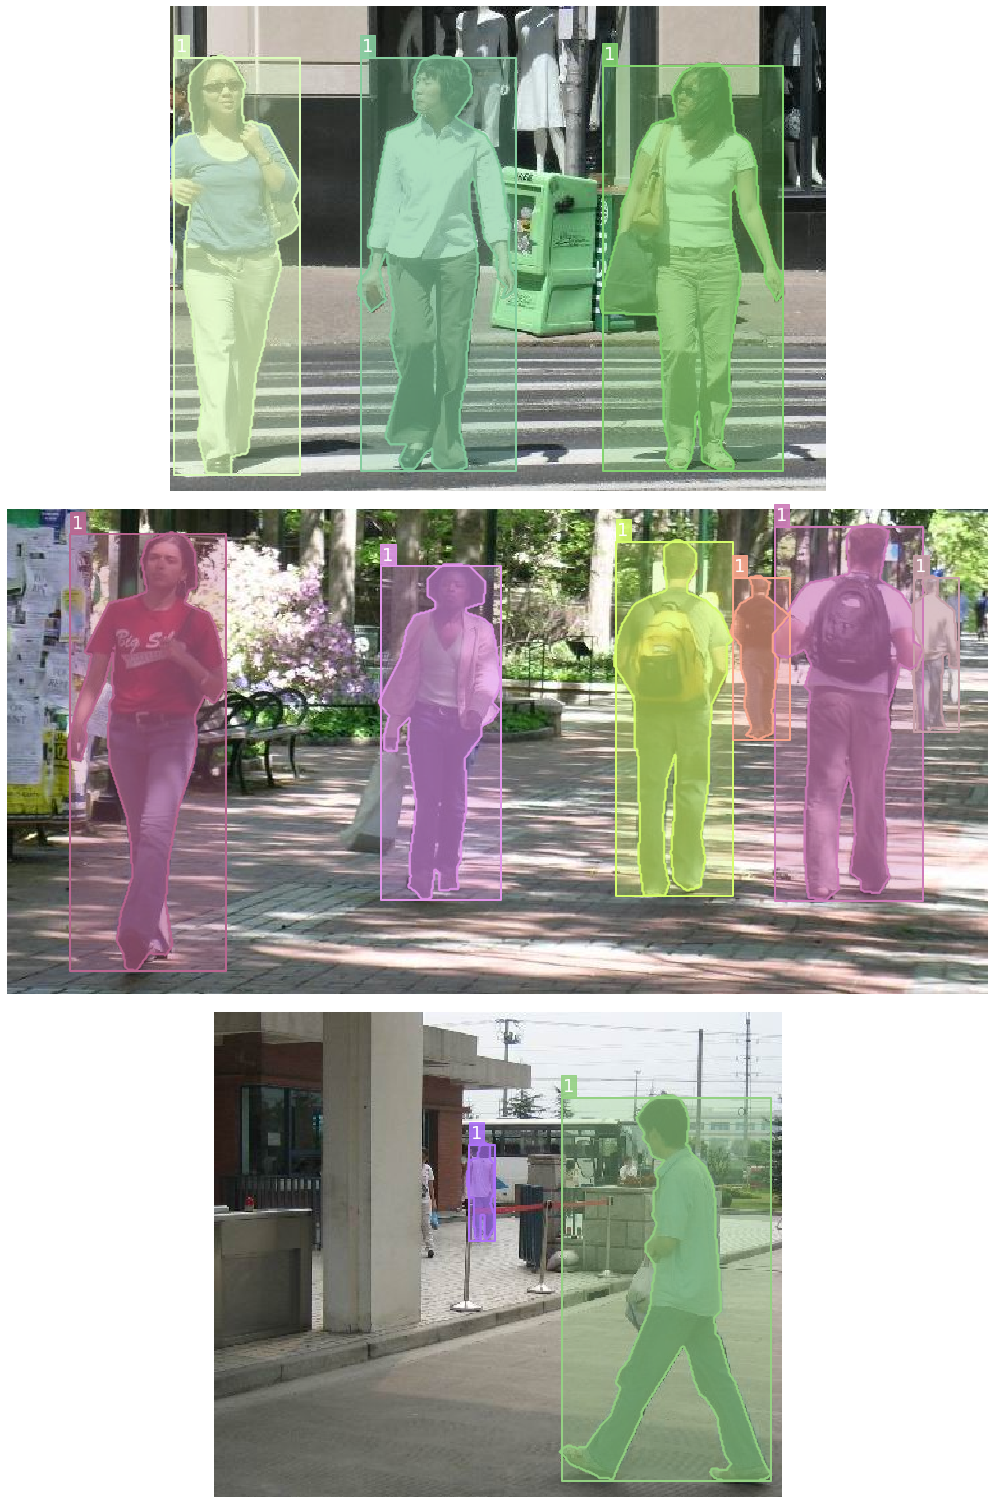

In [8]:
grid2([partial(show_record, r=r) for r in rtrain[42:45]])

## Transforms and dataloaders

In [9]:
tfms = AlbumentationTransformer([A.HorizontalFlip()])

In [10]:
ds_train = Dataset(rtrain, tfms)
ds_valid = Dataset(rvalid)

## Model and training

In [11]:
metrics = [COCOMetric(rvalid, id2cat)]


creating index...
index created!


In [12]:
model = MaskRCNNModel(2, metrics=metrics)

In [13]:
dl_train = RCNNDataloader(ds_train, batch_size=2, num_workers=8)
dl_valid = RCNNDataloader(ds_valid, batch_size=4, shuffle=False, num_workers=8)

In [14]:
trainer = Trainer(max_epochs=5, gpus=1)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [15]:
trainer.fit(model, dl_train, dl_valid)

INFO:lightning:
    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 43 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.649
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)


Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.969
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750

Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.962
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.963
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750

1

## Show results

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 390 and the array at index 1 has size 1

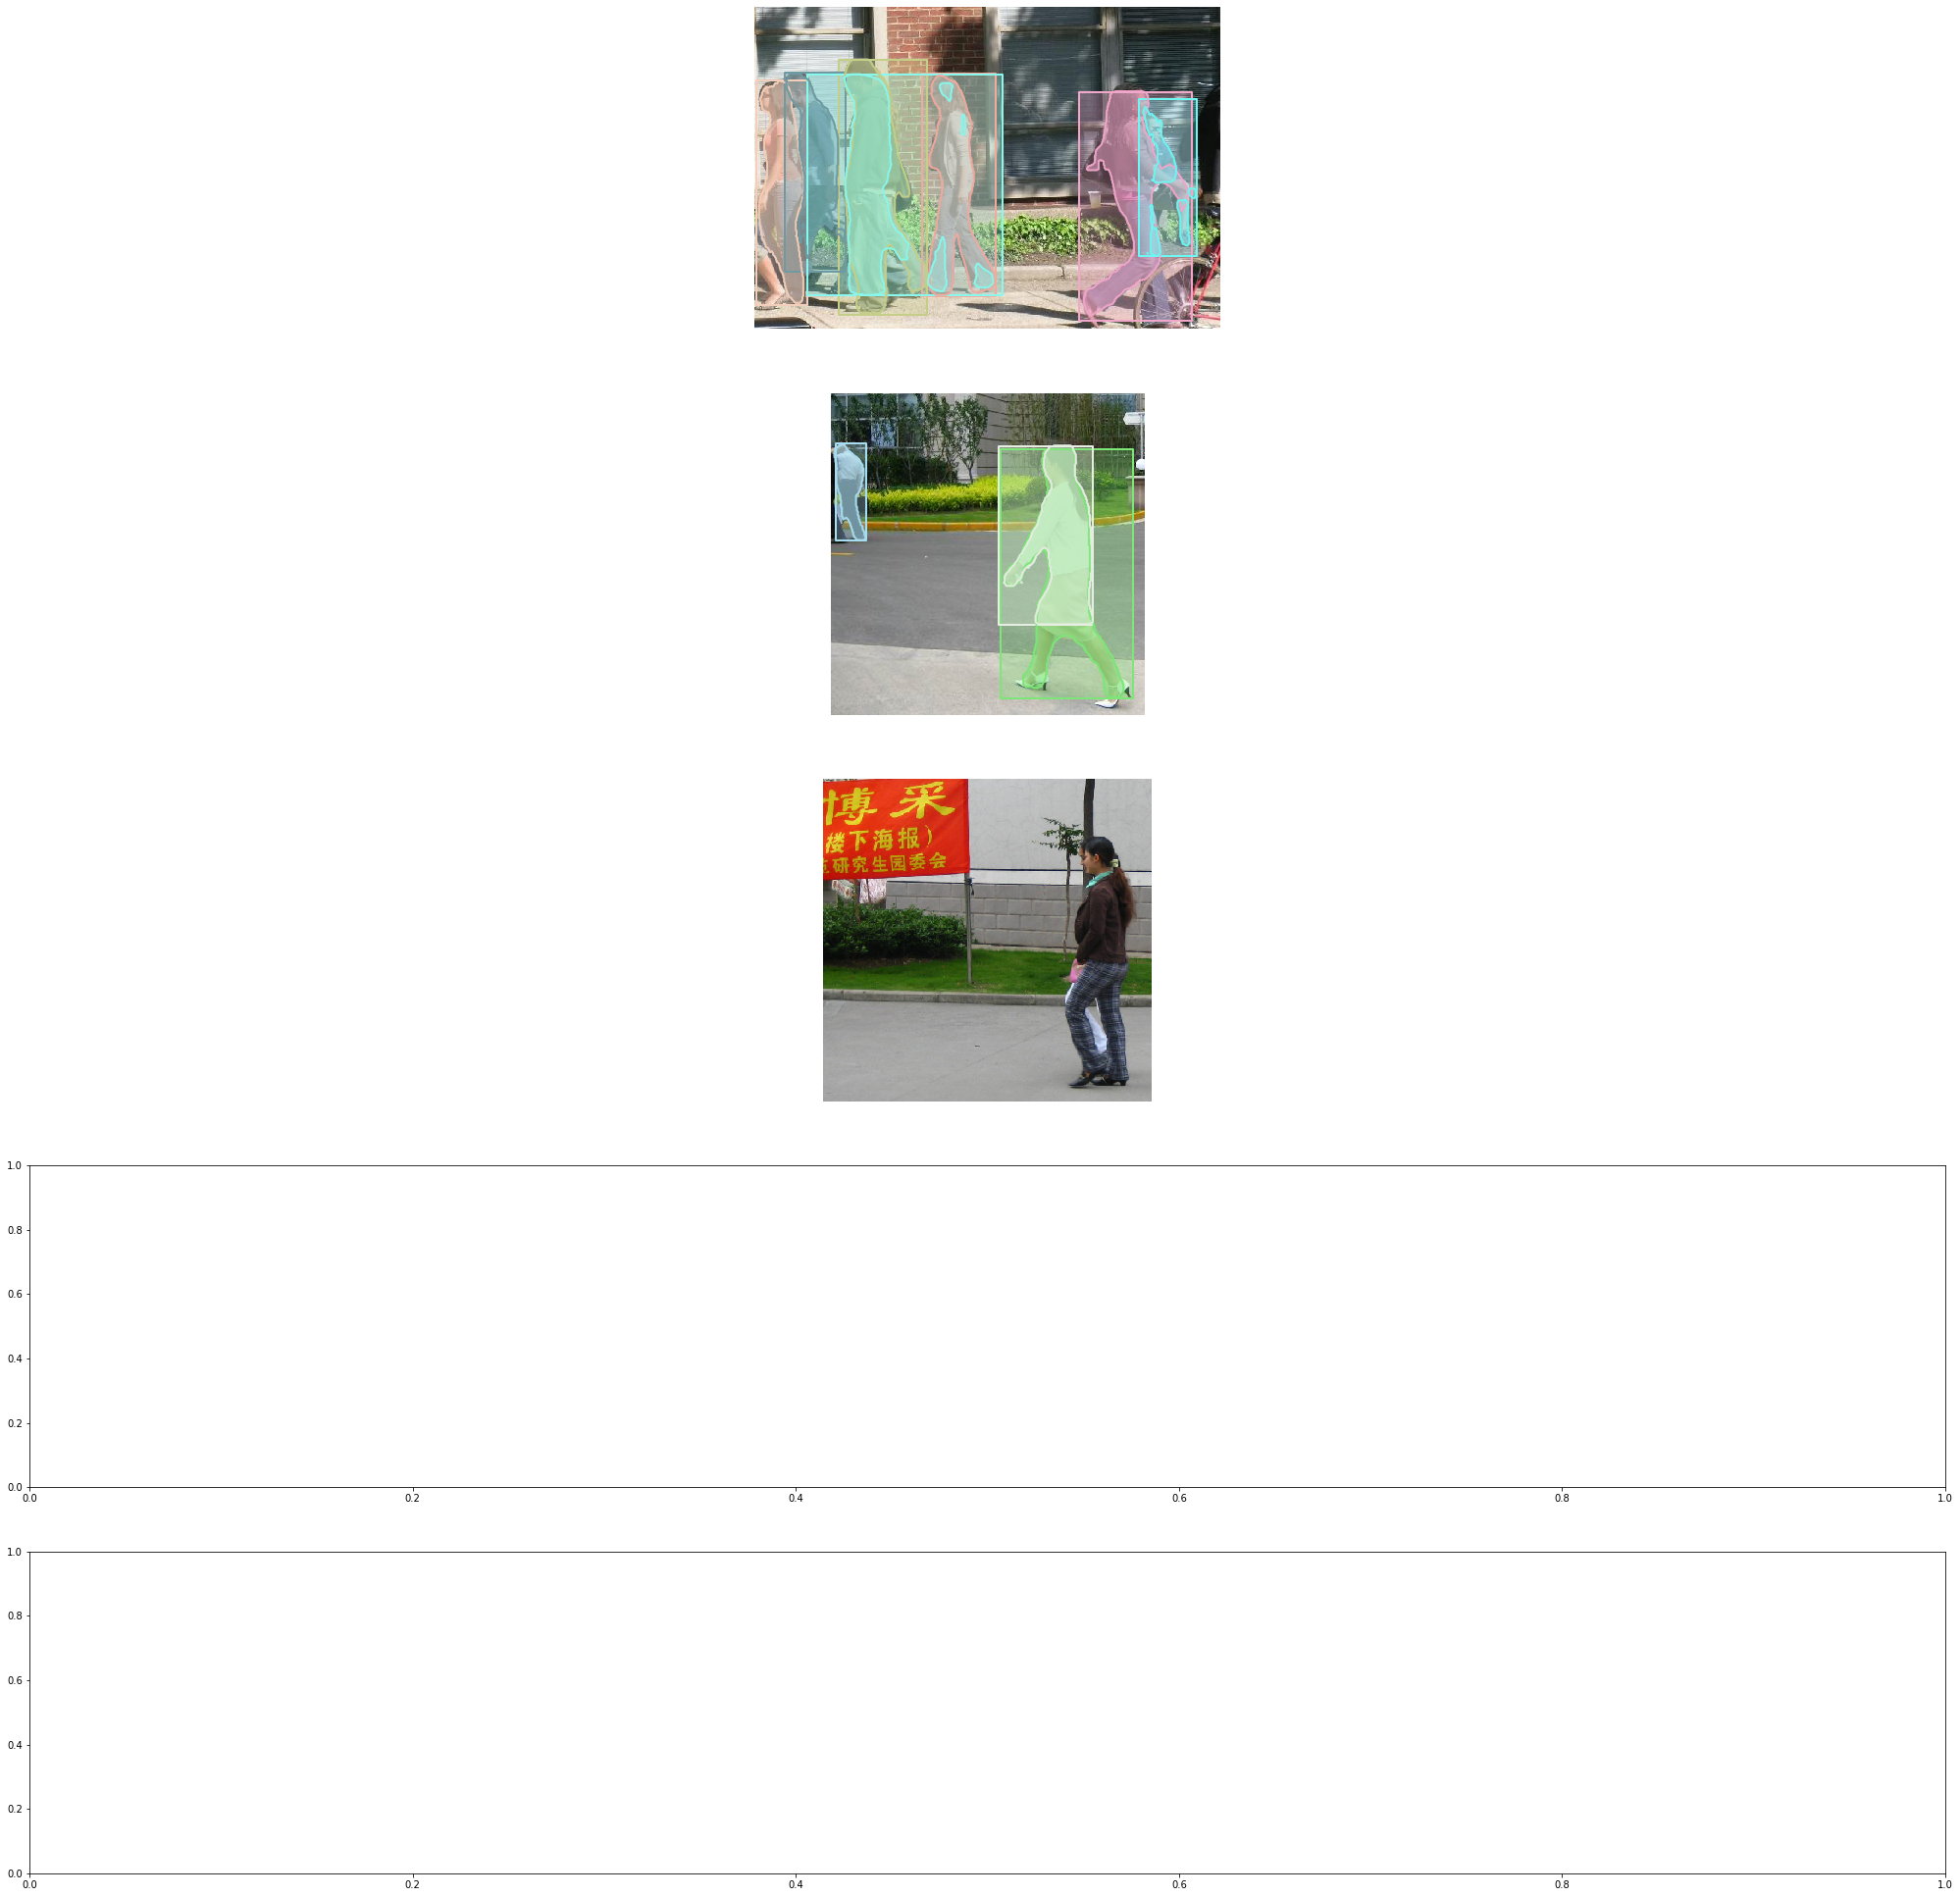

In [18]:
rs = random.choices(rvalid, k=5)
ims,preds = model.predict(rs=rs)
show_preds(ims, preds)